<a href="https://colab.research.google.com/github/thiagofuruchima/enem_ds/blob/main/enem_data_study.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#ENEM - Data Study

A statistical inference study about brazilian high school students using 2019 ENEM dataset.

##1. Problem Understanding

We're going to use a random sample of the ENEM data (Brazil's SAT like exam) to answer the following questions regarding brazilian high school students.

1 - Do brazilian students declared themselves as white skinned have higher average scores than those self declared as brown skinned?

2 - Do brazilian students declared themselves as brown skinned have higher average scores than those self declared as black?

3 - Do brazilian female students have higher essay average scores than male students? 

4 - Do brazilian students who chose 'english' as a foreign language have higher average scores than those who chose 'spanish'?

## 2. Data Understanding and Preparation

We're using a 0.1% random sample of the whole ENEM exam dataset. The whole dataset can be accessed in [Dados Abertos INEP](https://www.gov.br/inep/pt-br/acesso-a-informacao/dados-abertos).

First, let's load the dataset and take a look at the data.

In [117]:
# laod the libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy import stats
# from statsmodels import stats

In [118]:
# read the sample dataset
df = pd.read_csv("https://github.com/thiagofuruchima/enem_ds/raw/main/data/enem_random_sample_01_percent.csv")

In [119]:
# check the row/column count
df.shape

(5095, 136)

In [120]:
# check the first 5 rows
df.head()

,NU_INSCRICAO,NU_ANO,CO_MUNICIPIO_RESIDENCIA,NO_MUNICIPIO_RESIDENCIA,CO_UF_RESIDENCIA,SG_UF_RESIDENCIA,NU_IDADE,TP_SEXO,TP_ESTADO_CIVIL,TP_COR_RACA,TP_NACIONALIDADE,CO_MUNICIPIO_NASCIMENTO,NO_MUNICIPIO_NASCIMENTO,CO_UF_NASCIMENTO,SG_UF_NASCIMENTO,TP_ST_CONCLUSAO,TP_ANO_CONCLUIU,TP_ESCOLA,TP_ENSINO,IN_TREINEIRO,CO_ESCOLA,CO_MUNICIPIO_ESC,NO_MUNICIPIO_ESC,CO_UF_ESC,SG_UF_ESC,TP_DEPENDENCIA_ADM_ESC,TP_LOCALIZACAO_ESC,TP_SIT_FUNC_ESC,IN_BAIXA_VISAO,IN_CEGUEIRA,IN_SURDEZ,IN_DEFICIENCIA_AUDITIVA,IN_SURDO_CEGUEIRA,IN_DEFICIENCIA_FISICA,IN_DEFICIENCIA_MENTAL,IN_DEFICIT_ATENCAO,IN_DISLEXIA,IN_DISCALCULIA,IN_AUTISMO,IN_VISAO_MONOCULAR,...,TX_RESPOSTAS_CH,TX_RESPOSTAS_LC,TX_RESPOSTAS_MT,TP_LINGUA,TX_GABARITO_CN,TX_GABARITO_CH,TX_GABARITO_LC,TX_GABARITO_MT,TP_STATUS_REDACAO,NU_NOTA_COMP1,NU_NOTA_COMP2,NU_NOTA_COMP3,NU_NOTA_COMP4,NU_NOTA_COMP5,NU_NOTA_REDACAO,Q001,Q002,Q003,Q004,Q005,Q006,Q007,Q008,Q009,Q010,Q011,Q012,Q013,Q014,Q015,Q016,Q017,Q018,Q019,Q020,Q021,Q022,Q023,Q024,Q025
0,190002290964,2019,2927408,Salvador,29,BA,30,M,1,3,1,2927408.0,Salvador,29.0,BA,1,9,1,1.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,...,ECEADCABDBDCDBEECDAEDACEBDDDBAECBCAEBECDBBECC,EDACD99999DCBDBCCABEDACECBAEBADDACEBEDCADDBEBD...,CEBBBDDBACEDCDABBDEBDADDCBBBCAEDDAAEDBCCADBCB,0,DEADBAAAEBEECEBCBCBCBDADAEABCEDDDDADCBEECACBC,BACCCBABBADCBCEEEBCACACEEDBCCADBEADBADBBBACDB,BDABEABCADBCBAADDBECDAAECDAECBECBCCDEEAAADDBBC...,AADDDBEEEBEDDBEBACABCDBABECECACAECDCBDCCEDCDA,1.0,80.0,120.0,80.0,140.0,100.0,520.0,C,B,B,B,3,B,A,B,C,A,A,B,A,A,A,A,A,A,B,B,A,B,B,B,B
1,190004057495,2019,3550308,São Paulo,35,SP,29,F,1,3,1,2913606.0,Ilhéus,29.0,BA,1,11,1,1.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,...,CCADAECCDBACABAEDAEABEDEACBCBCAABEDDCEDBEACEA,99999CABDDDBEDBCECEBACBDCBEEDECBAEEEACEACDCECA...,CDCBADABCCDBEACEDEDACBEDCBDBABAAEDCCBEDBABEDB,1,DADCCEBBCCACBEEBEEBACBCDDDDADBCBBCEAEADEADAAE,ACACEEBCCBABADBBBACDBBACCCCADCEBADCBEEDBBEADB,EBBADCABDABACBCEBDEEAAADDBECDECDDBADBCDAAECBCC...,DBEBACABCDBABECEEEDCBDCCEDCDABEDAADDDECACAECB,1.0,140.0,180.0,120.0,120.0,100.0,660.0,H,H,C,F,6,C,A,B,C,A,A,B,A,A,A,B,A,A,B,B,A,D,A,B,B
2,190002548758,2019,2304400,Fortaleza,23,CE,31,M,1,3,1,2304400.0,Fortaleza,23.0,CE,1,13,1,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,...,BCACABABBABCECEEABCCCABDEDBCCADEEEDDADBEEAEAB,BDABE99999BCBADDDBEEDAAEBABCCBECBCCAEBAADDADBC...,BACAABDBDECBAECBABBACEAEDDEAECDBEACCCBDCCEDA*,0,BEEAAEBEEBADEADDADAEABCEDDDBCBCBCCACBCDADCCEB,BACCCBABBADCBCEEEBCACACEEDBCCADBEADBADBBBACDB,BDABEABCADBCBAADDBECDAAECDAECBECBCCDEEAAADDBBC...,BEDEEEAADBEBACABCDBABECECACADCBDCCEDCDABECDDD,1.0,160.0,140.0,120.0,160.0,120.0,700.0,E,E,E,D,4,D,A,B,B,B,A,B,A,B,A,A,A,A,B,A,A,E,B,C,B
3,190001162162,2019,2304400,Fortaleza,23,CE,20,F,1,1,1,2304400.0,Fortaleza,23.0,CE,1,2,1,1.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,...,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,C,C,B,B,4,C,A,B,B,A,A,B,A,A,A,B,A,A,B,A,A,C,A,A,B
4,190001424877,2019,2807501,Tomar do Geru,28,SE,18,F,1,3,1,2802106.0,Estância,28.0,SE,3,0,1,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,...,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,B,B,A,A,4,B,A,B,C,A,B,B,A,A,A,A,A,A,B,B,A,C,A,A,A


In [121]:
# check the last 5 rows
df.tail()

,NU_INSCRICAO,NU_ANO,CO_MUNICIPIO_RESIDENCIA,NO_MUNICIPIO_RESIDENCIA,CO_UF_RESIDENCIA,SG_UF_RESIDENCIA,NU_IDADE,TP_SEXO,TP_ESTADO_CIVIL,TP_COR_RACA,TP_NACIONALIDADE,CO_MUNICIPIO_NASCIMENTO,NO_MUNICIPIO_NASCIMENTO,CO_UF_NASCIMENTO,SG_UF_NASCIMENTO,TP_ST_CONCLUSAO,TP_ANO_CONCLUIU,TP_ESCOLA,TP_ENSINO,IN_TREINEIRO,CO_ESCOLA,CO_MUNICIPIO_ESC,NO_MUNICIPIO_ESC,CO_UF_ESC,SG_UF_ESC,TP_DEPENDENCIA_ADM_ESC,TP_LOCALIZACAO_ESC,TP_SIT_FUNC_ESC,IN_BAIXA_VISAO,IN_CEGUEIRA,IN_SURDEZ,IN_DEFICIENCIA_AUDITIVA,IN_SURDO_CEGUEIRA,IN_DEFICIENCIA_FISICA,IN_DEFICIENCIA_MENTAL,IN_DEFICIT_ATENCAO,IN_DISLEXIA,IN_DISCALCULIA,IN_AUTISMO,IN_VISAO_MONOCULAR,...,TX_RESPOSTAS_CH,TX_RESPOSTAS_LC,TX_RESPOSTAS_MT,TP_LINGUA,TX_GABARITO_CN,TX_GABARITO_CH,TX_GABARITO_LC,TX_GABARITO_MT,TP_STATUS_REDACAO,NU_NOTA_COMP1,NU_NOTA_COMP2,NU_NOTA_COMP3,NU_NOTA_COMP4,NU_NOTA_COMP5,NU_NOTA_REDACAO,Q001,Q002,Q003,Q004,Q005,Q006,Q007,Q008,Q009,Q010,Q011,Q012,Q013,Q014,Q015,Q016,Q017,Q018,Q019,Q020,Q021,Q022,Q023,Q024,Q025
5090,190004067563,2019,3550308,São Paulo,35,SP,17,M,1,1,1,3550308.0,São Paulo,35.0,SP,2,0,2,1.0,0,35001659.0,3550308.0,São Paulo,35.0,SP,2.0,1.0,1.0,0,0,0,0,0,0,0,0,0,0,0,0,...,ACCCEECBADACDBAECCDAECBACDBEEECCCBBADEDBAADAE,99999DAACEDBCEACBACECBDBBAAADCBDAEDCDDCEBEEECD...,ABBACCACAEDAEDCBADADCAEACBCCBBCECEBBABADDDCEC,1,DEADBAAAEBEECEBCBCBCBDADAEABCEDDDDADCBEECACBC,EEBCEEDBADBBCBABCCADCEBACDBBACCACACBEADBBADCB,ADBBEDCABAABBCBCDAAECDDDBAAAECADECDCEBDEEAECBD...,AADDDBEEEBEDDBEBACABCDBABECECACAECDCBDCCEDCDA,1.0,120.0,120.0,120.0,120.0,0.0,480.0,D,D,C,F,3,B,A,B,C,A,A,B,B,B,A,B,A,A,C,B,B,D,B,A,B
5091,190005942525,2019,4315909,Rodeio Bonito,43,RS,18,F,1,1,1,4315909.0,Rodeio Bonito,43.0,RS,2,0,2,1.0,0,43116019.0,4315909.0,Rodeio Bonito,43.0,RS,2.0,1.0,1.0,0,0,0,0,0,0,0,0,0,0,0,0,...,BDCBECAACDBEDBEACBEDABCEACEBDAEBDACCECAEBAEDB,99999EDEEBCAEBCEDCDDAEABADCEBDDADBECBDBEEBABCA...,DECDBBDCCEECBEBECBACDBEADCEBADBCADCEABAEDBAEA,1,DADCCEBBCCACBEEBEEBACBCDDDDADBCBBCEAEADEADAAE,CBABADBBCEEEBCBADCBEEDBBEADBBACDBBACCCCADACAC,BBEDABDACACBABAECBBCCADCEBDBBCDDEEAAADDBECDECA...,DBEBACABCDBABECEEEDCBDCCEDCDABEDAADDDECACAECB,1.0,120.0,120.0,120.0,120.0,140.0,620.0,H,F,F,D,2,D,A,B,C,B,A,B,A,B,A,B,A,A,B,A,A,C,A,B,B
5092,190002772261,2019,2609105,Machados,26,PE,17,M,1,1,1,2611606.0,Recife,26.0,PE,2,0,2,NaN,0,26070090.0,2609105.0,Machados,26.0,PE,2.0,1.0,1.0,0,0,0,0,0,0,0,0,0,0,0,0,...,ABCACADAACABDDECCEBAADDCBDDDABEEBDECBCBABDCAE,AAAAA99999CDAECAECCDEBCEADCDEBCBAEDAADEEACBDCA...,ECEBCAADADACDACAEDEDEBDDEDABEDBADEDACCECABDCE,0,DEADBAAAEBEECEBCBCBCBDADAEABCEDDDDADCBEECACBC,CBABADBBCEEEBCBADCBEEDBBEADBBACDBBACCCCADACAC,BBEDABDACACBABAECBBCCADCEBDBBCDDEEAAADDBECDECA...,AADDDBEEEBEDDBEBACABCDBABECECACAECDCBDCCEDCDA,1.0,140.0,160.0,160.0,180.0,160.0,800.0,C,A,A,A,8,A,A,B,D,A,A,B,A,A,A,A,A,A,B,A,A,B,A,A,A
5093,190001276489,2019,2927705,Santa Cruz Cabrália,29,BA,24,M,0,5,1,2903300.0,Barro Preto,29.0,BA,1,6,1,1.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,...,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,B,B,C,F,9,C,A,B,D,A,A,B,A,A,A,A,A,A,B,B,A,D,A,A,B
5094,190005984465,2019,3550308,São Paulo,35,SP,19,F,1,3,2,NaN,NaN,NaN,NaN,1,2,1,1.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,...,AEBECCBBAAABBDDDCBBAEBCEDCACCBCCADB..CBAAACCC,99999AEDEECECBBCCCBBDDECBBAAACCAACACADECBDEACC...,BDBDEDBDCBBCBEBADBCBDDCCCBECBECBCEBCBCACCEDEB,1,DADCCEBBCCACBEEBEEBACBCDDDDADBCBBCEAEADEADAAE,EEBCEEDBADBBCBABCCADCEBACDBBACCACACBEADBBADCB,ADBBEDCABAABBCBCDAAECDDDBAAAECADECDCEBDEEAECBD...,DBEBACABCDBABECEEEDCBDCCEDCDABEDAADDDECACAECB,1.0,120.0,100.0,80.0,80.0,60.0,440.0,E,F,F,D,5,I,A,B,C,B,B,B,A,B,B,B,A,A,B,A,A,E,A,C,B


It look's like the dataset is alright!

Now, lets check the datatypes. Since there are more than a hundred columns, and we'll only use few of them, we're going to check only the important ones in our context. Also, we'll be translating these columns to english.

In [122]:
# translate only the columns we'll be using on our analysis
df.rename(columns={'NU_IDADE':'AGE',
                   'TP_SEXO':'GENDER',
                   'TP_COR_RACA':'SKIN_COLOR',
                   'TP_LINGUA':'FOREIGN_LANGUAGE',
                   'NU_NOTA_CN':'GRADE_NATURAL_SCIENCES',
                   'NU_NOTA_CH':'GRADE_HUMAN_SCIENCES',
                   'NU_NOTA_LC':'GRADE_LANGUAGE_SCIENCES',
                   'NU_NOTA_MT':'GRADE_MATH_SCIENCES',
                   'NU_NOTA_REDACAO':'GRADE_ESSAY'}, inplace=True)

In [123]:
# define the important columns for our analysis
important_columns = ['AGE', 'GENDER',  'SKIN_COLOR',
                     'FOREIGN_LANGUAGE','GRADE_NATURAL_SCIENCES','GRADE_HUMAN_SCIENCES',
                     'GRADE_LANGUAGE_SCIENCES','GRADE_MATH_SCIENCES','GRADE_ESSAY']

Lets check the first rows again, but now, only the important ones.

In [124]:
df[important_columns].head()

,AGE,GENDER,SKIN_COLOR,FOREIGN_LANGUAGE,GRADE_NATURAL_SCIENCES,GRADE_HUMAN_SCIENCES,GRADE_LANGUAGE_SCIENCES,GRADE_MATH_SCIENCES,GRADE_ESSAY
0,30,M,3,0,406.9,449.9,530.0,408.0,520.0
1,29,F,3,1,415.2,521.1,529.5,544.2,660.0
2,31,M,3,0,566.3,626.9,607.7,612.3,700.0
3,20,F,1,1,NaN,NaN,NaN,NaN,NaN
4,18,F,3,1,NaN,NaN,NaN,NaN,NaN


It look's like some values are 'coded' so we need to 'translate' that.

In [125]:
df['GENDER'] = df['GENDER'].map({'M':'Male',
                  'F':'Female'})

df['SKIN_COLOR'] = df['SKIN_COLOR'].map({0:'Not Informed',
                     1:'White',
                     2:'Black',
                     3:'Brown',
                     4:'Yellow',
                     5:'Indigenous'})

df['FOREIGN_LANGUAGE'] = df['FOREIGN_LANGUAGE'].map({0:'English',
                     1:'Spanish'})

Now, lets check the datatypes.

In [126]:
# check the columns types
df[important_columns].dtypes

AGE                          int64
GENDER                      object
SKIN_COLOR                  object
FOREIGN_LANGUAGE            object
GRADE_NATURAL_SCIENCES     float64
GRADE_HUMAN_SCIENCES       float64
GRADE_LANGUAGE_SCIENCES    float64
GRADE_MATH_SCIENCES        float64
GRADE_ESSAY                float64
dtype: object

Most of them are correct. But some categorical types were handled incorrectly. Let's fix that.

In [127]:
# change the type of columns for 'GENDER', 'RACE' and 'FOREING LANGUAGE' to category
df['GENDER'] = df['GENDER'].astype('category')
df['SKIN_COLOR'] = df['SKIN_COLOR'].astype('category')
df['FOREIGN_LANGUAGE'] = df['FOREIGN_LANGUAGE'].astype('category')

Let's check for duplicated and null values, as these can have a huge impact on our analysis.

In [128]:
# check for duplicates
df.duplicated().sum()

0

No duplicates! What about null values?

In [129]:
# check for missing values
df[important_columns].isna().sum()

AGE                           0
GENDER                        0
SKIN_COLOR                    0
FOREIGN_LANGUAGE              0
GRADE_NATURAL_SCIENCES     1391
GRADE_HUMAN_SCIENCES       1181
GRADE_LANGUAGE_SCIENCES    1181
GRADE_MATH_SCIENCES        1391
GRADE_ESSAY                1181
dtype: int64

Altought we don't have any duplicates, we've got a lot of missing values on our dataset. Let's take a look at these cases, to see if we can spot a reason for that.

In [130]:
# check the rows with na in selected columns
df[df[important_columns].isna().any(axis=1)][important_columns]

,AGE,GENDER,SKIN_COLOR,FOREIGN_LANGUAGE,GRADE_NATURAL_SCIENCES,GRADE_HUMAN_SCIENCES,GRADE_LANGUAGE_SCIENCES,GRADE_MATH_SCIENCES,GRADE_ESSAY
3,20,Female,White,Spanish,NaN,NaN,NaN,NaN,NaN
4,18,Female,Brown,Spanish,NaN,NaN,NaN,NaN,NaN
6,22,Male,Brown,Spanish,NaN,NaN,NaN,NaN,NaN
9,55,Male,Black,English,NaN,NaN,NaN,NaN,NaN
15,16,Female,Brown,Spanish,416.1,NaN,NaN,385.6,NaN
...,...,...,...,...,...,...,...,...,...
5069,18,Female,White,English,NaN,379.0,440.6,NaN,360.0
5077,21,Male,White,English,NaN,436.0,451.4,NaN,320.0
5084,22,Male,Black,English,NaN,NaN,NaN,NaN,NaN
5085,21,Male,White,Spanish,NaN,NaN,NaN,NaN,NaN


It looks like the everyone has their personal information complete, but not everybody has a score. This is because students have to fill a form in order to take the exam, but some of them, don't actually take the test.

Since our analysis is focused only on those who completed the whole exam, we're going to discard the rows with missing information for the grades.

In [131]:
df.dropna(subset=['GRADE_NATURAL_SCIENCES','GRADE_HUMAN_SCIENCES','GRADE_LANGUAGE_SCIENCES','GRADE_MATH_SCIENCES','GRADE_ESSAY'], inplace=True)

Now, let's do some graphical EDA. For the numericals, we're going to plot the distribution, for the categoricals, the count/proportion.

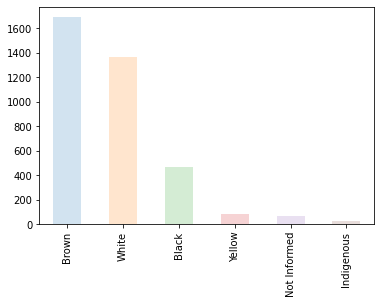

In [132]:
# Plot the 'Skin Color' count
df['SKIN_COLOR'].value_counts(dropna=False).plot(kind='bar', color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b'], alpha=.2)
plt.show()

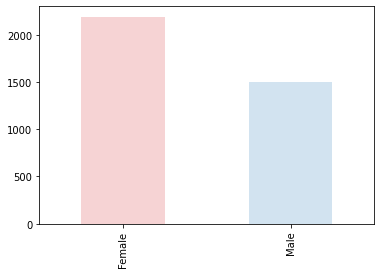

In [133]:
# Plot the gender count
df['GENDER'].value_counts().plot(kind='bar', color=['#d62728', '#1f77b4'], alpha=.2)
plt.show()

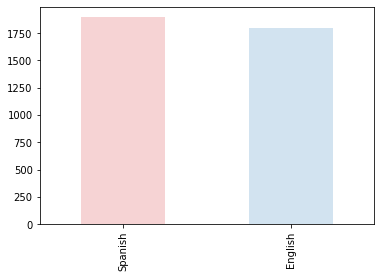

In [134]:
# Plot the 'foreign language' count
df['FOREIGN_LANGUAGE'].value_counts().plot(kind='bar', color=['#d62728', '#1f77b4'], alpha=.2)
plt.show()

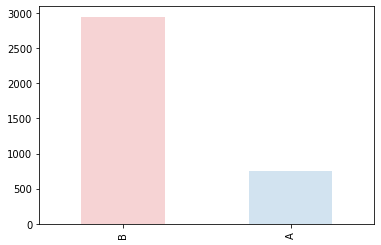

In [135]:
# Plot the 'Internet Access' count (A="Don't have internet Access at home", B="Have internet Access at home")
df['Q025'].value_counts().plot(kind='bar', color=['#d62728', '#1f77b4'], alpha=.2)
plt.show()

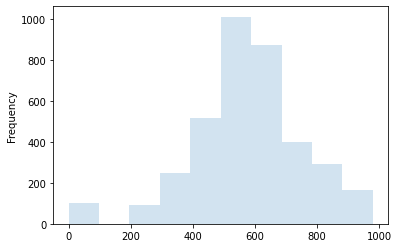

In [136]:
# Plot a histogram for the  'Essay Score'
df['GRADE_ESSAY'].plot(kind='hist', alpha=0.2)
plt.show()

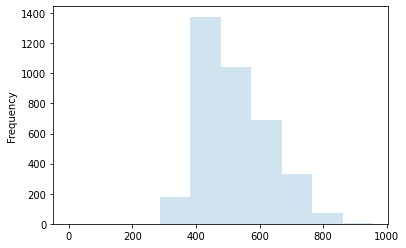

In [137]:
# Plot a histogram for the  'Math Score'
df['GRADE_MATH_SCIENCES'].plot(kind='hist', alpha=0.2)
plt.show()

Let's now  define the significance level (alpha) for our tests, and the function we're going to be using for getting the bootstrap distributions.

Also, let's compute the total score for each student.

In [138]:
# define our significance level as 5%
alpha = 0.05

In [139]:
def get_bootstrap_means(group1, group2):
#   """ Compute N bootstrap sample means for for two groups"""
  n_bootstraps = 1000
  group1_mean_list, group2_mean_list = [], []
  for _ in range(n_bootstraps):
    # Take the bootstrap sample for each group independently
    group1_mean = group1.sample(group1.shape[0], replace=True).mean()
    group2_mean = group2.sample(group2.shape[0], replace=True).mean()
    group1_mean_list.append(group1_mean)
    group2_mean_list.append(group2_mean)
  
  return pd.Series(group1_mean_list), pd.Series(group2_mean_list)

In [140]:
# Create a column with the total score
df['TOTAL_SCORE'] = df[['GRADE_NATURAL_SCIENCES','GRADE_HUMAN_SCIENCES','GRADE_LANGUAGE_SCIENCES','GRADE_MATH_SCIENCES','GRADE_ESSAY']].sum(axis=1)

## 4. Modeling

### 4.1 - Do brazilian students declared themselves as white skinned have higher average scores than those self declared as brown skinned?

To answer this question, we're going to perform the following hypothesis test:



$$ H_0 : \mu_{score\_white} \le \mu_{score\_brown} $$

$$ H_1 : \mu_{score\_white} \gt \mu_{score\_brown} $$

First, we're going to generate 10.000 bootstrap means for each group, and use that to empirically create the sample distribution for the mean score.

In [144]:
white_mean_score_list, brown_mean_score_list = get_bootstrap_means(df.query('SKIN_COLOR=="White"')['TOTAL_SCORE'], df.query('SKIN_COLOR=="Brown"')['TOTAL_SCORE'])

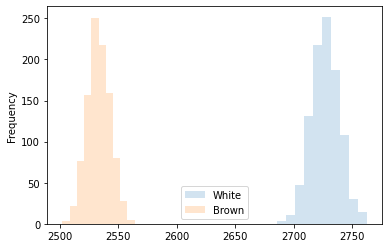

In [148]:
white_mean_score_list.plot(kind='hist', alpha=.2, label="White")
brown_mean_score_list.plot(kind='hist', alpha=.2, label="Brown")
plt.legend()
plt.show()

Let's calculate the p-value and the 'bootstrap equivalent' t-statistic for our hypothesis.

In [149]:
# compute the probability of h0
pvalue_boot = (white_mean_score_list <= brown_mean_score_list).mean()

# Compute the bootstrap equivalent for the t-statistic
diff = white_mean_score_list-brown_mean_score_list
statistic_boot = (diff.mean())/diff.std()

statistic_boot, pvalue_boot

(12.565415478248267, 0.0)

Let's use Scipy to compare our bootstrap hypotesis test, with the t-test commonly used on these contexts, that is, the "two sample t-test".

In [151]:
# use scipy.stats to perform a "two-sample t-test"
statistic_ttest, pvalue_ttest = stats.ttest_ind(df.query('SKIN_COLOR=="White"')['TOTAL_SCORE'], df.query('SKIN_COLOR=="Brown"')['TOTAL_SCORE'])
statistic_ttest, pvalue_ttest/2

(12.942333582285, 1.2201053368599237e-37)

As expected, the empirical (bootstrap) hypotesis test has reached the same conclusion as the parametric t-test.

In [152]:
# compare the boot pvalue and ttest pvalue to the 5th decimal
print("Bootstrap P-Value:", round(pvalue_boot, 5))
print("T-Test P-Value:", round(pvalue_ttest/2, 5))

Bootstrap P-Value: 0.0
T-Test P-Value: 0.0


In [26]:
# Compare the p_value to the significance level
if (pvalue_boot < alpha):
  print("Reject the Null Hypothesis.")
else:
  print("Fail to Reject the Null Hypothesis.")

Reject the Null Hypothesis.


**At the significance level of 0.05, we have evidence to reject the null hypothesis in favor of the alternative. Brazilian students self declared as white skinned have higher average scores than those with brown skin.**

### 4.2 - Do brazilian students declared themselves as brown skinned have higher average scores than those self declared as black?

To answer this question, we're going to perform the following hypothesis test:

$$H_0: \mu_{score\_brown} \le \mu_{score\_black}$$

$$H_1: \mu_{score\_brown} \gt \mu_{score\_black}$$

Again, we're going to generate 10.000 bootstrap means for each group, and use that to empirically create the sample distribution for the mean.

In [153]:
brown_mean_score_list, black_mean_score_list = get_bootstrap_means(df.query('SKIN_COLOR=="Brown"')['TOTAL_SCORE'], df.query('SKIN_COLOR=="Black"')['TOTAL_SCORE'])

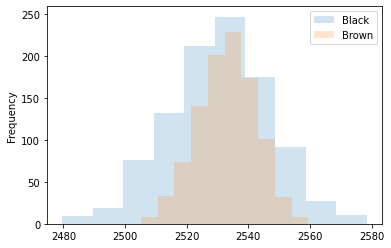

In [154]:
black_mean_score_list.plot(kind='hist', alpha=.2, label="Black")
brown_mean_score_list.plot(kind='hist', alpha=.2, label="Brown")
plt.legend()
plt.show()

Let's calculate the p-value and the 'bootstrap equivalent' t-statistic for our hypothesis.

In [155]:
# compute the probability of h0
pvalue_boot = (brown_mean_score_list <= black_mean_score_list).mean()

# Compute the bootstrap equivalent for the t-statistic
diff = brown_mean_score_list-black_mean_score_list
statistic_boot = (diff.mean())/diff.std()

statistic_boot, pvalue_boot

(0.12794148893144633, 0.473)

Let's use Scipy to compare our bootstrap hypotesis test, with the 'conventional' "two sample t-test".

In [157]:
# use scipy.stats to perform a "two-sample t-test"
statistic_ttest, pvalue_ttest = stats.ttest_ind(df.query('SKIN_COLOR=="Brown"')['TOTAL_SCORE'], df.query('SKIN_COLOR=="Black"')['TOTAL_SCORE'])
statistic_ttest, pvalue_ttest/2

(0.1298328155589739, 0.4483554166808009)

As expected, the empirical (bootstrap) hypotesis test has reached the same conclusion as the parametric t-test.

In [158]:
# compare the boot pvalue and ttest pvalue to the 5th decimal
print("Bootstrap P-Value:", round(pvalue_boot, 5))
print("T-Test P-Value:", round(pvalue_ttest/2, 5))

Bootstrap P-Value: 0.473
T-Test P-Value: 0.44836


In [159]:
# Compare the p_value to the significance level
if (pvalue_boot < alpha):
  print("Reject the Null Hypothesis.")
else:
  print("Fail to Reject the Null Hypothesis.")

Fail to Reject the Null Hypothesis.


**At the significance level of 0.05, we don't have evidence to reject the null hypothesis. Brazilian students self declared as brown skinned don't have higher average scores than those self declared as black.**

### 4.3 - Do brazilian female students have higher essay average scores than male students?

To answer this question, we're going to perform the following hypothesis test:

$$H_0: \mu_{score\_female} \le \mu_{score\_male}$$

$$H_1: \mu_{score\_female} \gt \mu_{score\_male}$$

Again, we're going to generate 10.000 bootstrap means for each group, and use that to empirically create the sample distribution for the mean.

In [162]:
female_mean_score_list, male_mean_score_list = get_bootstrap_means(df.query('GENDER=="Female"')['GRADE_ESSAY'], df.query('GENDER=="Male"')['GRADE_ESSAY'])

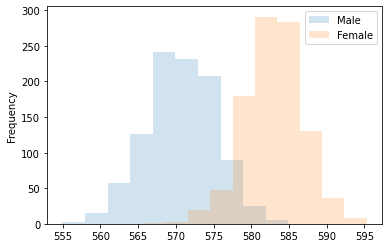

In [163]:
male_mean_score_list.plot(kind='hist', alpha=.2, label="Male")
female_mean_score_list.plot(kind='hist', alpha=.2, label="Female")
plt.legend()
plt.show()

In [164]:
# Compute the bootstrap equivalent for the t-statistic
diff = female_mean_score_list-male_mean_score_list
(diff.mean())/diff.std()

2.061268168376927

In [166]:
pvalue_boot = (female_mean_score_list<=male_mean_score_list).mean()
pvalue_boot

0.023

In [172]:
# Compare the p_value to the significance level
if (pvalue_boot < alpha):
  print("Reject the Null Hypothesis.")
else:
  print("Fail to Reject the Null Hypothesis.")

Reject the Null Hypothesis.


**At the significance level of 0.05, we have evidence to reject the null hypothesis in favor of the alternative. Brazilian female students have higher average essay scores than male students**

### 4.4 - Do brazilian students who chose 'english' as a foreign language have higher average scores than those who chose 'spanish'?

To answer this question, we're going to perform the following hypothesis test:

$$H_0: \mu_{score\_english} \le \mu_{score\_spanish}$$

$$H_1: \mu_{score\_english} \gt \mu_{score\_spanish}$$

In [167]:
english_mean_score_list, spanish_mean_score_list = get_bootstrap_means(df.query('FOREIGN_LANGUAGE=="English"')['TOTAL_SCORE'], df.query('FOREIGN_LANGUAGE=="Spanish"')['TOTAL_SCORE'])

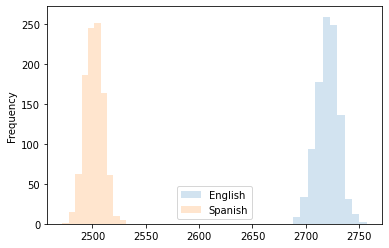

In [168]:
english_mean_score_list.plot(kind='hist', alpha=.2, label="English")
spanish_mean_score_list.plot(kind='hist', alpha=.2, label="Spanish")
plt.legend()
plt.show()

In [169]:
# Compute the bootstrap equivalent for the t-statistic
diff = english_mean_score_list-spanish_mean_score_list
(diff.mean())/diff.std()

16.396259964851318

In [170]:
# Computhe the bootstrap p-value
pvalue_boot = (english_mean_score_list<=spanish_mean_score_list).mean()
pvalue_boot

0.0

In [171]:
# Compare the p_value to the significance level
if (pvalue_boot < alpha):
  print("Reject the Null Hypothesis.")
else:
  print("Fail to Reject the Null Hypothesis.")

Reject the Null Hypothesis.


**At the significance level of 0.05, we have evidence to reject the null hypothesis in favor of the alternative. Brazilian students who pick english as their prefered foreing language have higher average total scores than those who pick spanish.**